In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
import joblib
import time
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
features, labels = [], []
training_files = ["dataset.csv"]

In [3]:
def scrape_data():
    global training_files
    global features
    global labels
    
    for fname in training_files:
        meal = open(fname, "rt")
        for line in meal:
            data_list = line.rsplit(",")
            if(len(data_list) != 5):
                print("error data")
            else:
                data_list[(len(data_list)-1)]=int(data_list[(len(data_list)-1)].replace('\n', ''))
                features.append(data_list[:(len(data_list)-1)])
                labels.append(data_list[(len(data_list)-1)])
        meal.close()
    
    data_counter = Counter(labels)
    print(data_counter)
    
    over = SMOTE()
    under = RandomUnderSampler()
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    features, labels = pipeline.fit_resample(features, labels)
    
    data_counter = Counter(labels)
    print(data_counter)
    
    scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
    scalar.fit(features)
    features = scalar.transform(features)
    
    features = np.array(features).astype(np.float64)
    features = features.tolist()
    
    print(f"Size of feature dataset : {len(features)}")
    print(f"Size of feature dataset : {len(labels)}")
    print("Features first and last entries:\n\t", end = "")
    print(features[:1] + features[(len(features)-1):])
    print("Labels first and last entries:\n\t", end = "")
    print(labels[:1] + labels[(len(features)-1):])
    
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.20, stratify=labels, random_state = 0)
    
    return np.asarray(features_train), np.asarray(labels_train), np.asarray(features_test), np.asarray(labels_test)

In [4]:
def generate_model(shape):
    model = Sequential()

    model.add(Dense(256, input_dim=shape, kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    print(model.summary())

    return model

In [5]:
data_train, label_train, data_eval, label_eval = scrape_data()

Counter({1: 200, 0: 200})
Counter({0: 200, 1: 200})
Size of feature dataset : 400
Size of feature dataset : 400
Features first and last entries:
	[[-0.012920370775532403, -0.9651018103262479, -0.7688378216430827, 0.9366236399938116], [0.650240912412335, 1.010803945378953, 0.5795242866434293, -0.9977641099473076]]
Labels first and last entries:
	[0, 1]


C:\Users\H P VICTUS\anaconda3\lib\site-packages\sklearn\utils\validation.py:964: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(


In [6]:
model = generate_model(len(data_train[0]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1280      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1280      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
checkpoint = ModelCheckpoint("dnnModel.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=1, mode='auto')

In [10]:
time_training_start = time.perf_counter()
history = model.fit(data_train, label_train, validation_split=0.2, epochs=100, verbose = 1, callbacks=[checkpoint,early])

Epoch 1/100
1/8 [==>...........................] - ETA: 7s - loss: 0.6909 - accuracy: 0.5625
Epoch 00001: val_loss improved from inf to 0.61011, saving model to dnnModel.h5
8/8 [==============================] - 1s 22ms/step - loss: 0.6735 - accuracy: 0.6562 - val_loss: 0.6101 - val_accuracy: 1.0000
Epoch 2/100
1/8 [==>...........................] - ETA: 0s - loss: 0.6481 - accuracy: 0.7812
Epoch 00002: val_loss improved from 0.61011 to 0.45774, saving model to dnnModel.h5
8/8 [==============================] - 0s 8ms/step - loss: 0.5719 - accuracy: 0.9297 - val_loss: 0.4577 - val_accuracy: 1.0000
Epoch 3/100
1/8 [==>...........................] - ETA: 0s - loss: 0.4786 - accuracy: 1.0000
Epoch 00003: val_loss improved from 0.45774 to 0.22122, saving model to dnnModel.h5
8/8 [==============================] - 0s 8ms/step - loss: 0.3893 - accuracy: 0.9805 - val_loss: 0.2212 - val_accuracy: 1.0000
Epoch 4/100
1/8 [==>...........................] - ETA: 0s - loss: 0.2910 - accuracy: 1.000

Epoch 30/100
1/8 [==>...........................] - ETA: 0s - loss: 0.0593 - accuracy: 0.9688
Epoch 00030: val_loss improved from 0.00154 to 0.00123, saving model to dnnModel.h5
8/8 [==============================] - 0s 8ms/step - loss: 0.0176 - accuracy: 0.9922 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 31/100
1/8 [==>...........................] - ETA: 0s - loss: 0.0427 - accuracy: 1.0000
Epoch 00031: val_loss improved from 0.00123 to 0.00054, saving model to dnnModel.h5
8/8 [==============================] - 0s 8ms/step - loss: 0.0150 - accuracy: 0.9961 - val_loss: 5.4102e-04 - val_accuracy: 1.0000
Epoch 32/100
1/8 [==>...........................] - ETA: 0s - loss: 0.0332 - accuracy: 0.9688
Epoch 00032: val_loss improved from 0.00054 to 0.00023, saving model to dnnModel.h5
8/8 [==============================] - 0s 8ms/step - loss: 0.0097 - accuracy: 0.9922 - val_loss: 2.3427e-04 - val_accuracy: 1.0000
Epoch 33/100
1/8 [==>...........................] - ETA: 0s - loss: 0.0035 - 

Epoch 58/100
1/8 [==>...........................] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000
Epoch 00058: val_loss improved from 0.00000 to 0.00000, saving model to dnnModel.h5
8/8 [==============================] - 0s 9ms/step - loss: 7.8747e-04 - accuracy: 1.0000 - val_loss: 2.1238e-06 - val_accuracy: 1.0000
Epoch 59/100
1/8 [==>...........................] - ETA: 0s - loss: 4.5856e-04 - accuracy: 1.0000
Epoch 00059: val_loss improved from 0.00000 to 0.00000, saving model to dnnModel.h5
8/8 [==============================] - 0s 11ms/step - loss: 9.6455e-04 - accuracy: 1.0000 - val_loss: 1.6156e-06 - val_accuracy: 1.0000
Epoch 60/100
1/8 [==>...........................] - ETA: 0s - loss: 2.3058e-04 - accuracy: 1.0000
Epoch 00060: val_loss improved from 0.00000 to 0.00000, saving model to dnnModel.h5
8/8 [==============================] - 0s 9ms/step - loss: 7.5163e-04 - accuracy: 1.0000 - val_loss: 1.2916e-06 - val_accuracy: 1.0000
Epoch 61/100
1/8 [==>...........................] - 

Epoch 85/100
1/8 [==>...........................] - ETA: 0s - loss: 8.0385e-05 - accuracy: 1.0000
Epoch 00085: val_loss did not improve from 0.00000
8/8 [==============================] - 0s 5ms/step - loss: 4.5628e-05 - accuracy: 1.0000 - val_loss: 9.2757e-08 - val_accuracy: 1.0000
Epoch 86/100
1/8 [==>...........................] - ETA: 0s - loss: 9.6280e-05 - accuracy: 1.0000
Epoch 00086: val_loss did not improve from 0.00000
8/8 [==============================] - 0s 4ms/step - loss: 1.6203e-04 - accuracy: 1.0000 - val_loss: 9.8353e-08 - val_accuracy: 1.0000
Epoch 87/100
1/8 [==>...........................] - ETA: 0s - loss: 9.4546e-06 - accuracy: 1.0000
Epoch 00087: val_loss did not improve from 0.00000
8/8 [==============================] - 0s 5ms/step - loss: 1.9294e-04 - accuracy: 1.0000 - val_loss: 8.9284e-08 - val_accuracy: 1.0000
Epoch 88/100
1/8 [==>...........................] - ETA: 0s - loss: 2.7235e-04 - accuracy: 1.0000
Epoch 00088: val_loss did not improve from 0.00000

In [11]:
print(f'Time to training : {time.perf_counter() - time_training_start}')

Time to training : 6.648430300000001


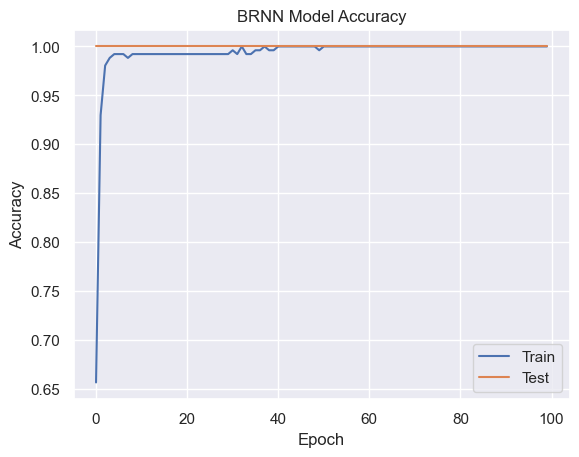

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BRNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
# plt.savefig('BRNN 200 Model Accuracy.png')
plt.show()

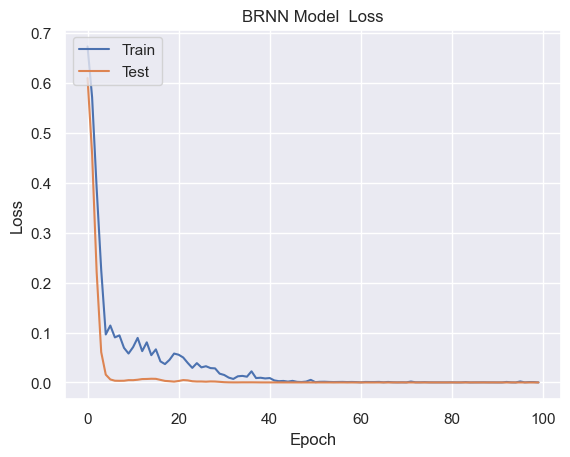

In [13]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BRNN Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('BRNN 200 Model Loss.png')
plt.show()

In [14]:
predict = model.predict(data_eval, verbose=1)

3/3 [==============================] - 0s 2ms/step


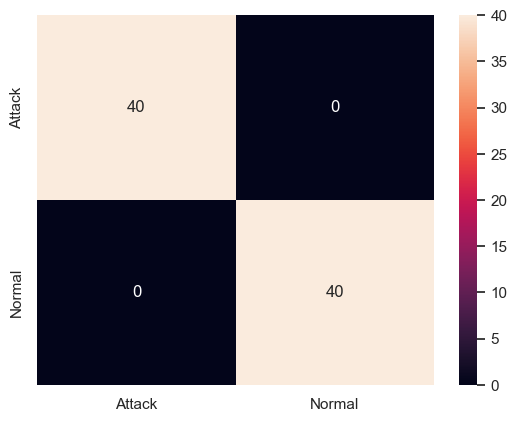

In [15]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = label_eval.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Attack","Normal"],columns = ["Attack","Normal"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

In [16]:
scores = model.evaluate(data_eval, label_eval)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

3/3 [==============================] - 0s 3ms/step - loss: 5.9595e-05 - accuracy: 1.0000
accuracy: 100.00%


In [17]:
print(classification_report(Y_testn,predictn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



In [18]:
lr_auc = roc_auc_score(Y_testn, predictn)
print('SVM: ROC AUC=%.3f' % (lr_auc))

SVM: ROC AUC=1.000


In [19]:
time_start = time.perf_counter()
predict = model.predict(data_eval[:1], verbose=1)
print(f"Time elapse for prediction : {time.perf_counter() - time_start}")
print(predict)

1/1 [==============================] - 0s 15ms/step
Time elapse for prediction : 0.03439179999999986
[[1.]]
